In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import os
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

# Carga de Datos

In [ ]:
data_path = '../data/stocks/processed/'

data_google = pd.read_parquet(os.path.join(data_path, 'GOOGL_data_processed.parquet'))
data_apple = pd.read_parquet(os.path.join(data_path, 'AAPL_data_processed.parquet'))
data_amazon = pd.read_parquet(os.path.join(data_path, 'AMZN_data_processed.parquet'))
data_meta = pd.read_parquet(os.path.join(data_path, 'META_data_processed.parquet'))
data_microsoft = pd.read_parquet(os.path.join(data_path, 'MSFT_data_processed.parquet'))
data_nvidia = pd.read_parquet(os.path.join(data_path, 'NVDA_data_processed.parquet'))
data_tesla = pd.read_parquet(os.path.join(data_path, 'TSLA_data_processed.parquet'))

# Descripción

In [5]:
print("Column names:", data_google.columns.tolist(), "\n")
print("="*70, "\n")
print("Missing values in the datasets:", 0, "\n")
print("="*70, "\n")
print("Size of the datasets:", data_google.shape, "\n")
print("="*70, "\n")
print("First 5 rows of the datasets:\n", data_google[['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_20', 'MACD', 'LOG_RETURN', 'ABS_LOG_RETURN', 'VOLATILITY']].head(), "\n")


Column names: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'SMA_20', 'SMA_30', 'MIDDLE_BAND', 'UPPER_BAND', 'LOWER_BAND', 'RSI_14', 'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'LOG_RETURN_HIGH', 'LOG_RETURN_LOW', 'LOG_RETURN_OPEN', 'LOG_RETURN_CLOSE', 'LOG_RETURN', 'ABS_LOG_RETURN', 'VOLATILITY', 'DAY_OF_WEEK', 'DAY_OF_WEEK_SIN', 'DAY_OF_WEEK_COS', 'MONTH', 'MONTH_SIN', 'MONTH_COS', 'DAY_OF_MONTH', 'DAY_OF_MONTH_SIN', 'DAY_OF_MONTH_COS', 'QUARTER', 'QUARTER_SIN', 'QUARTER_COS'] 


Missing values in the datasets: 0 


Size of the datasets: (2482, 35) 


First 5 rows of the datasets:
         Date      Close       High        Low       Open    Volume     SMA_20  \
0 2015-02-20  26.904440  27.191460  26.720708  27.191460  38234000  26.564036   
1 2015-02-23  26.566769  26.780296  26.417796  26.765399  32906000  26.546780   
2 2015-02-24  26.748016  26.785258  26.368135  26.395447  28406000  26.551572   
3 2015-02-25  27.179045  27.290277  26.716235  26.737590  40836000  26.616474 

# GRÁFICOS

## Precio de Cierre vs Retornos Logarítmicos

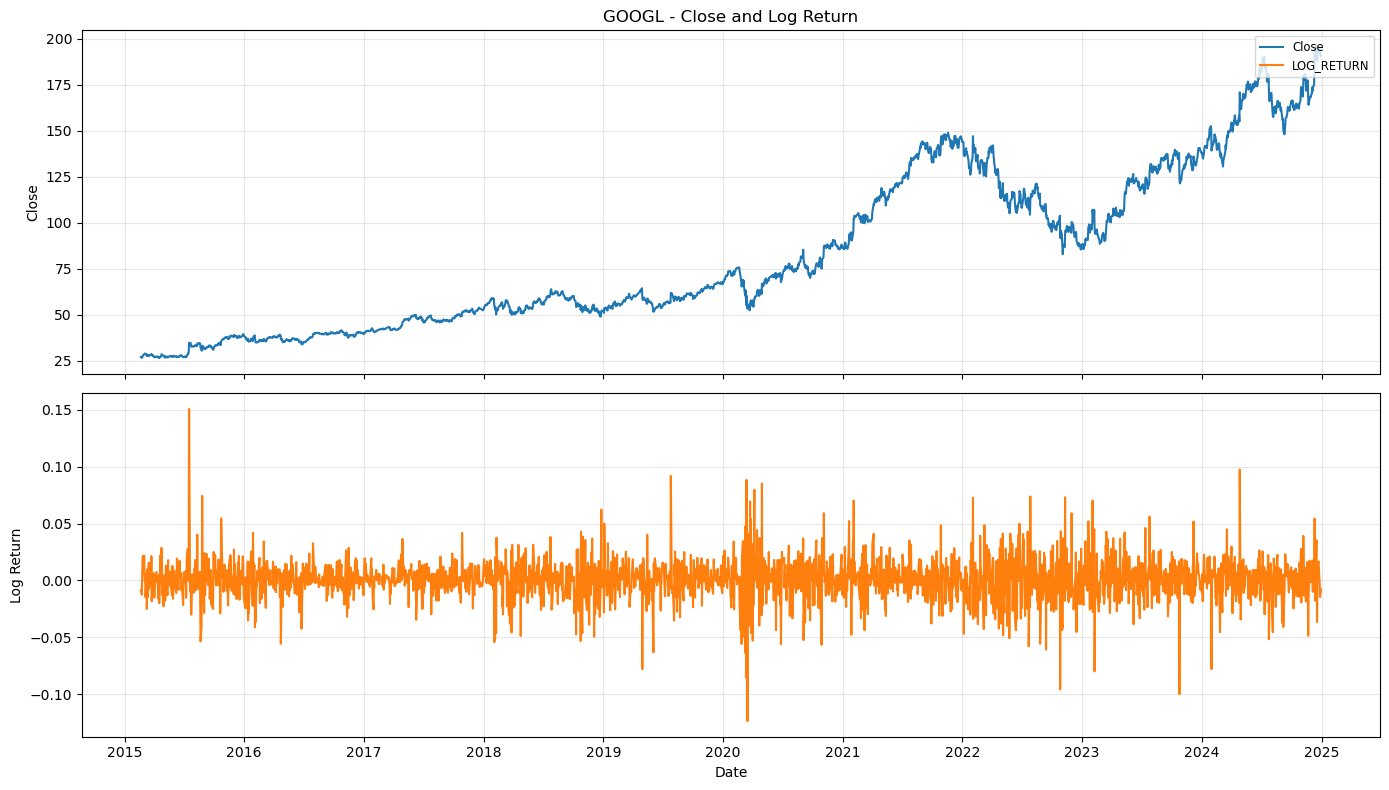

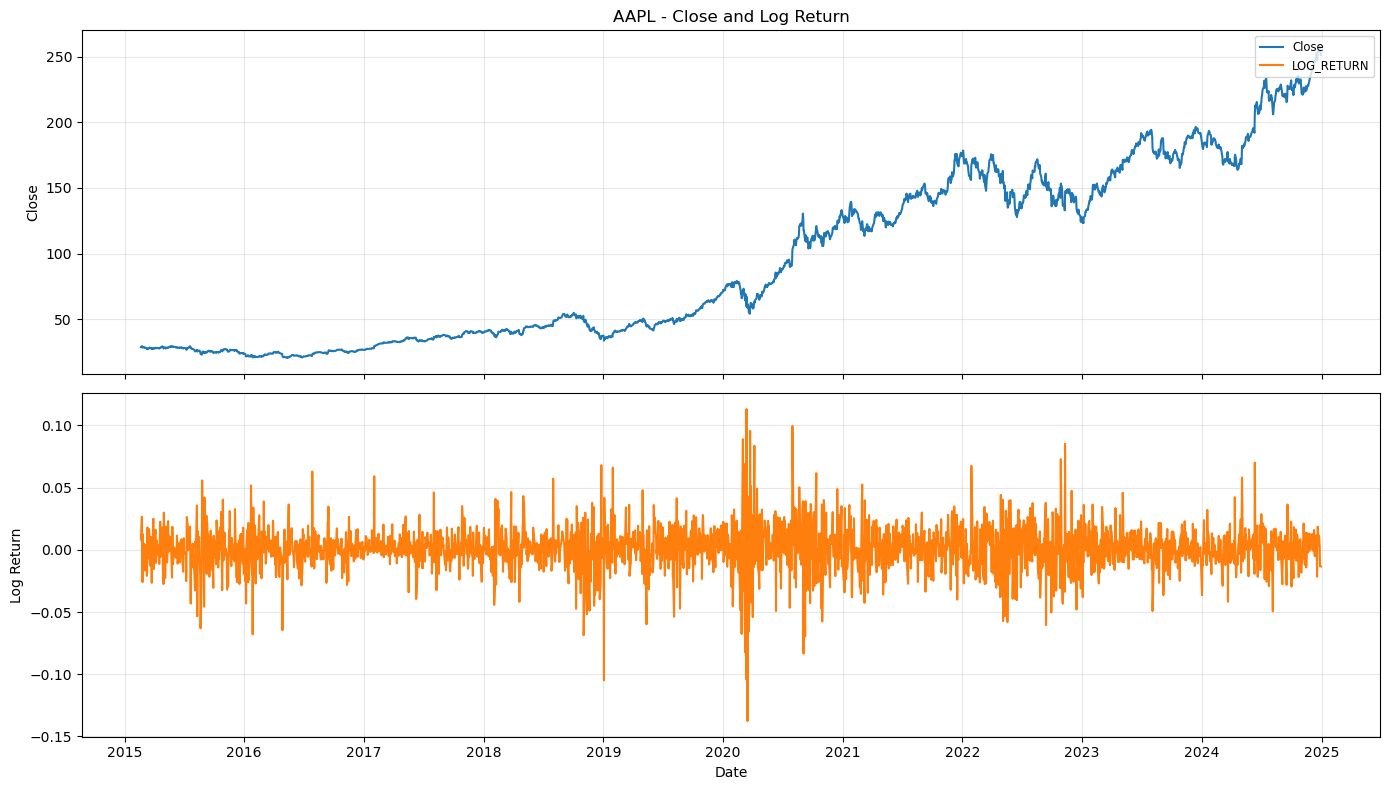

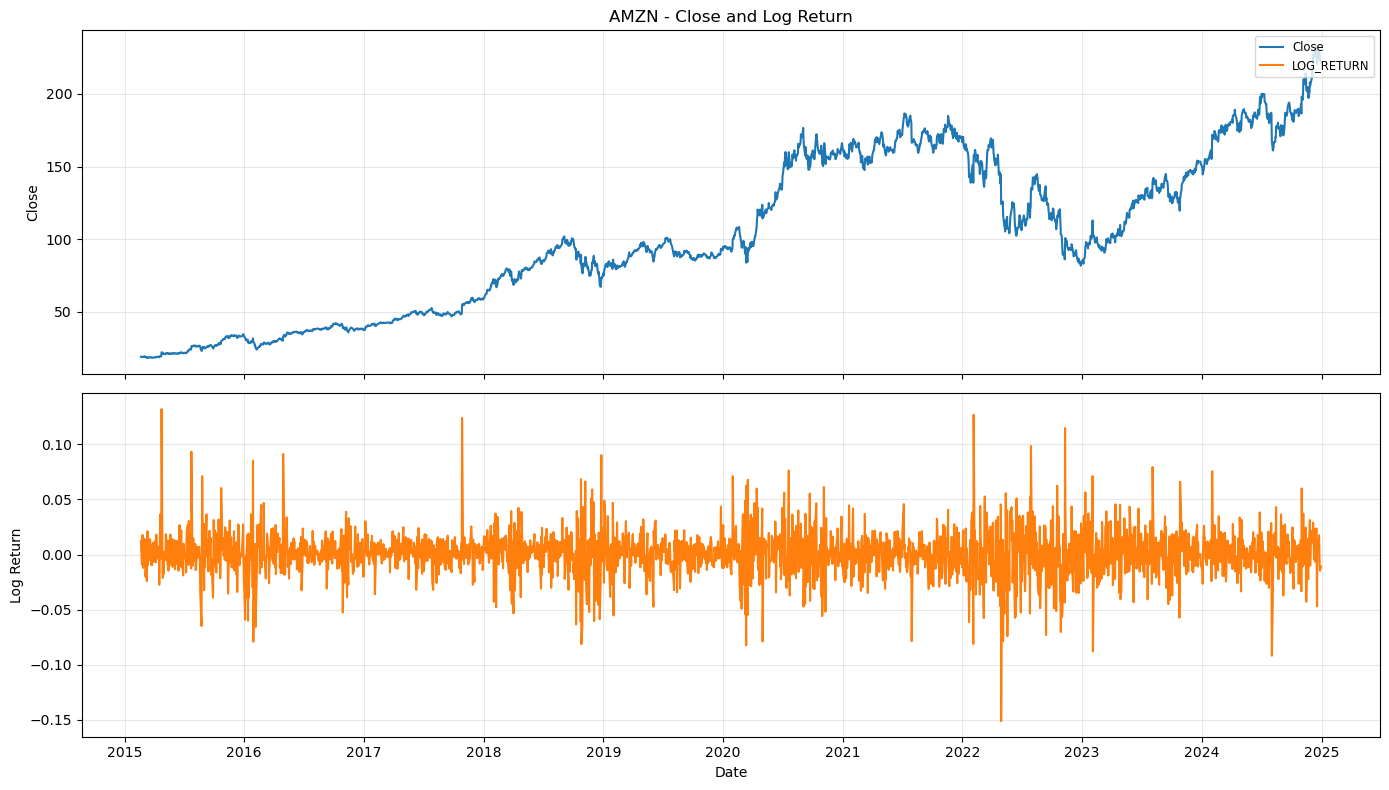

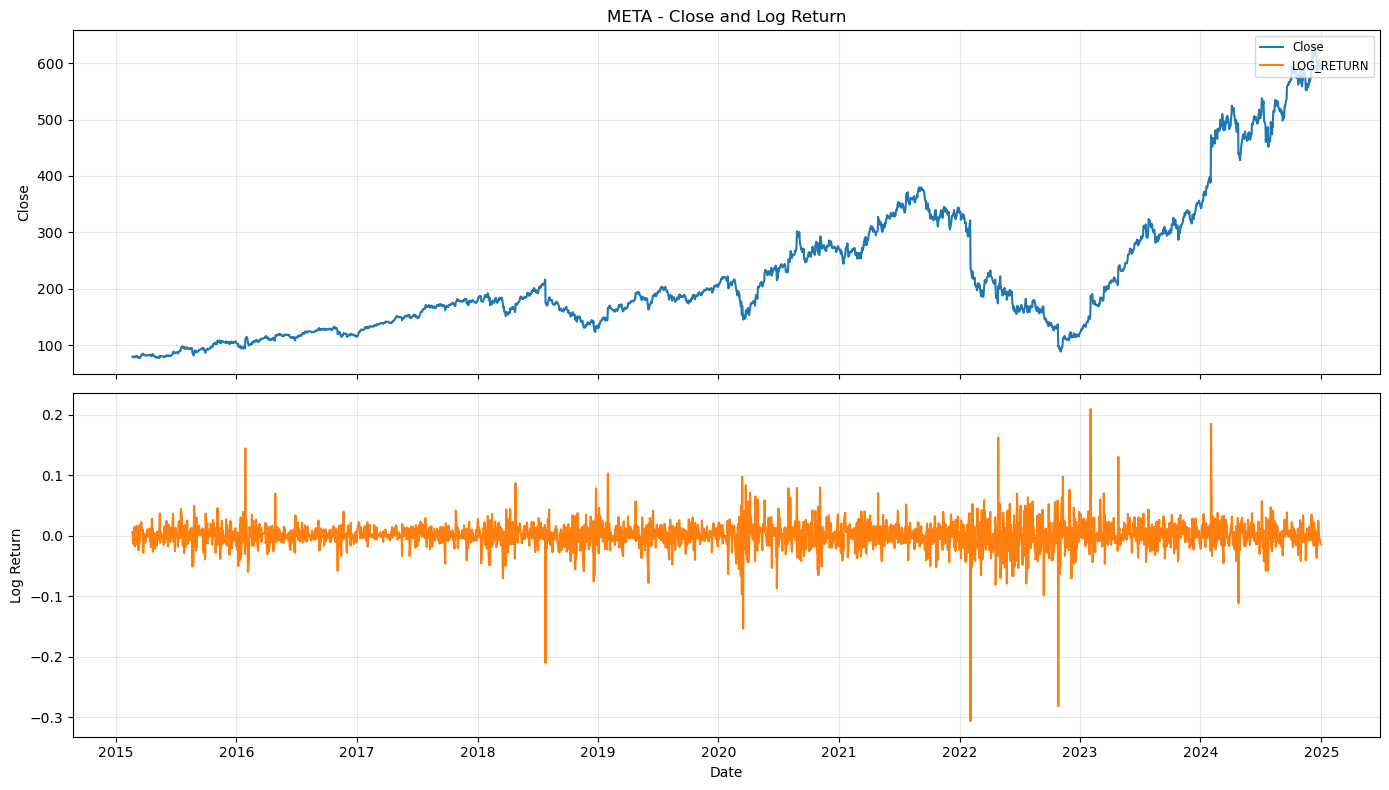

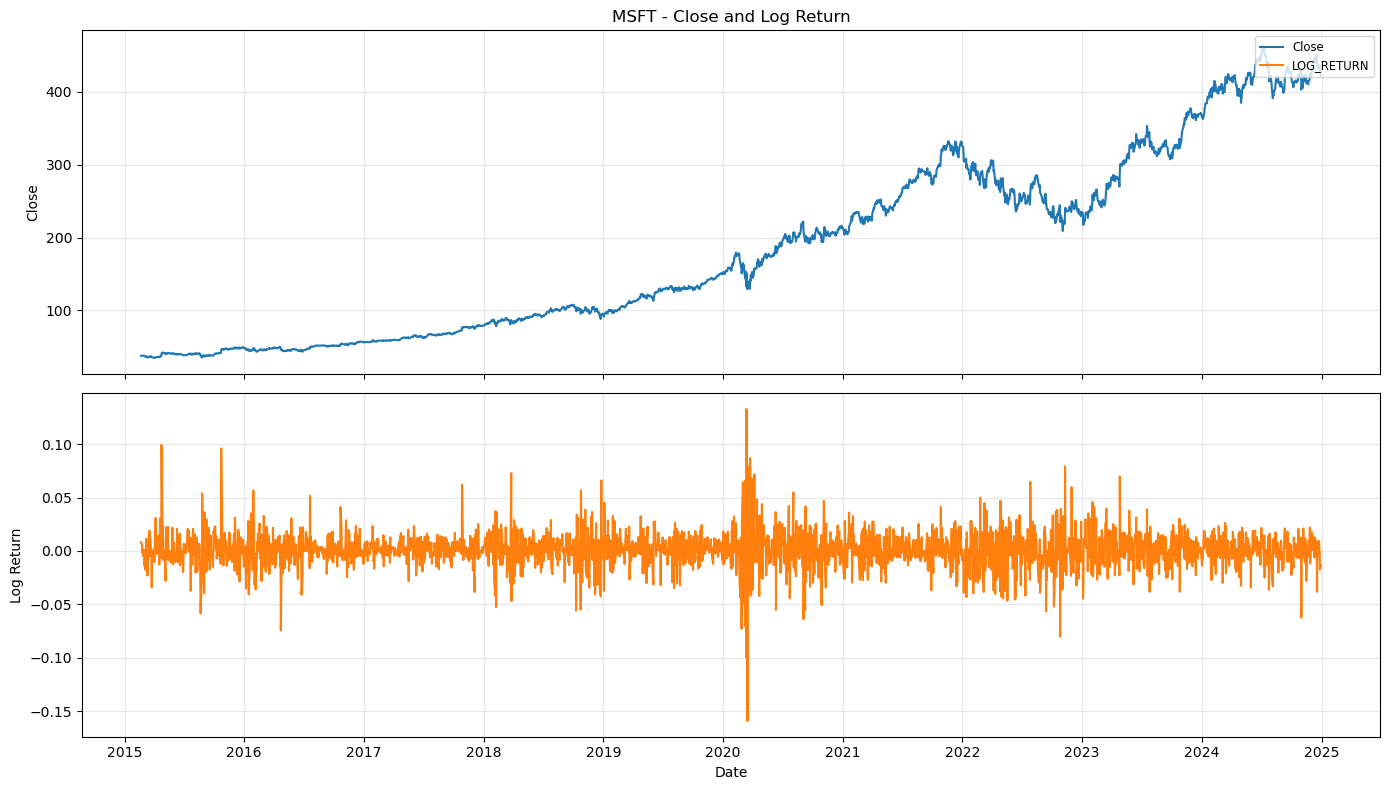

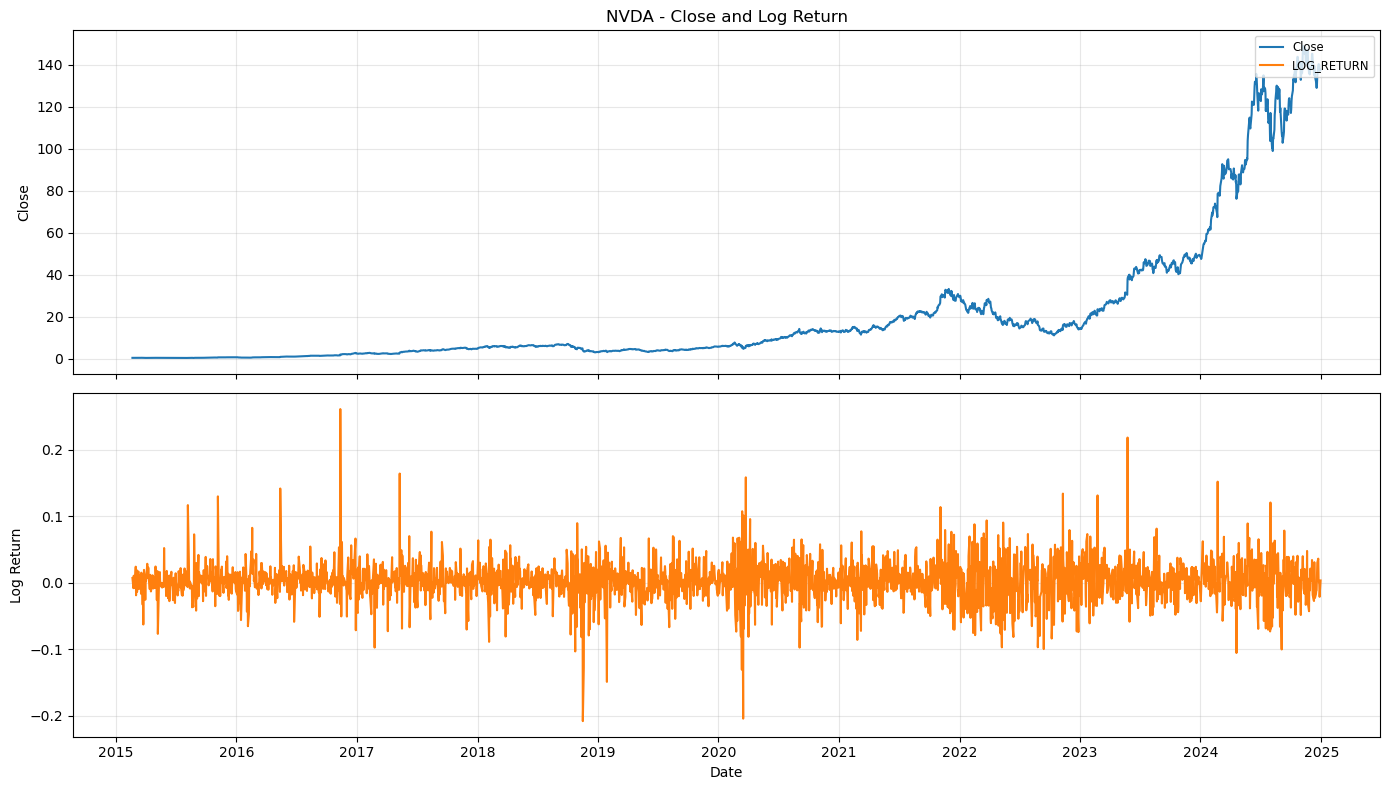

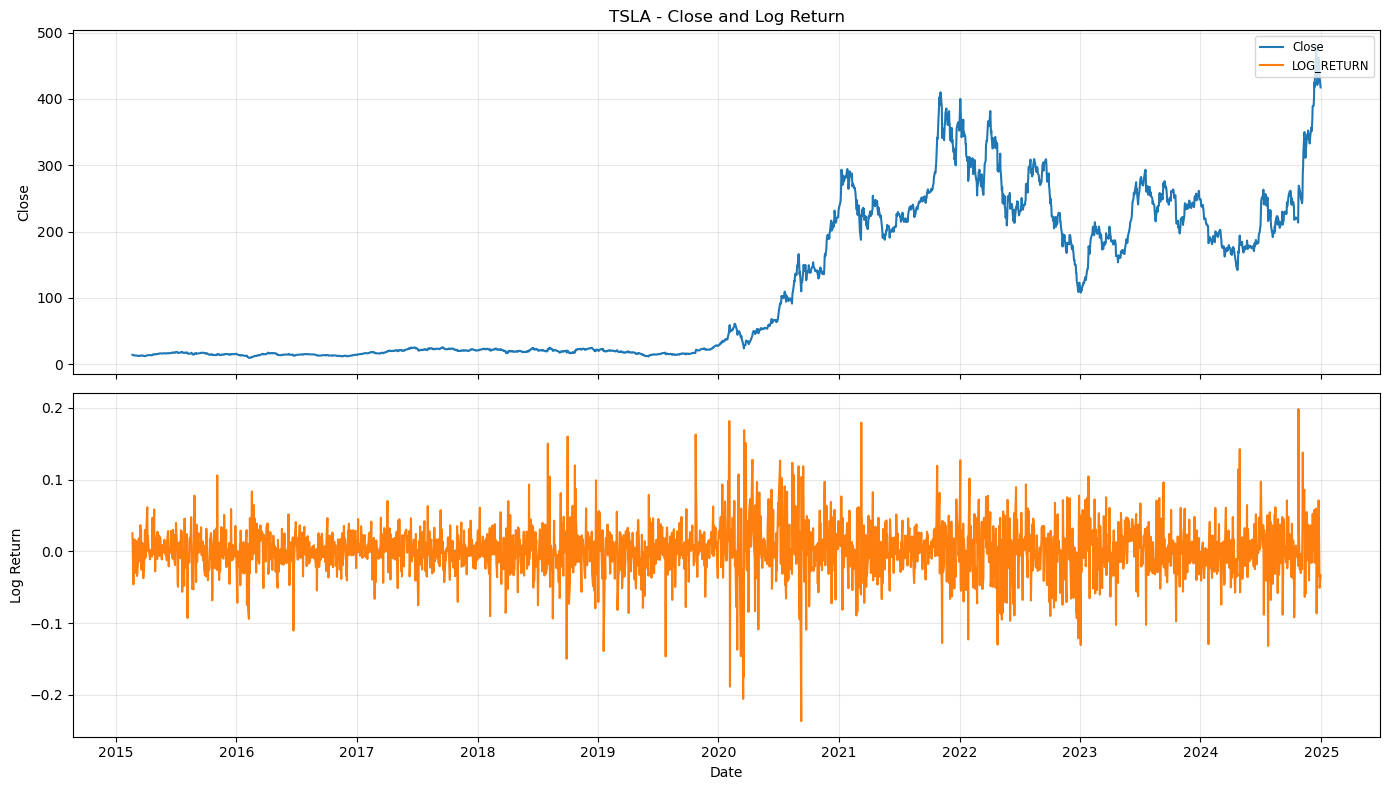

In [6]:
def plot_each_ticker_two_panels(stock_dict, save_dir='plots/stocks'):
    """For each ticker create one figure with 2 stacked subplots:
       - top: Close
       - bottom: LOG_RETURN
       Saves each figure to save_dir/{TICKER}_close_logreturn.png
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)

    for ticker, df in stock_dict.items():
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

        x = df['Date'] if 'Date' in df.columns else df.index

        # Top: Close
        if 'Close' in df.columns:
            ax1.plot(x, df['Close'], label='Close', color='tab:blue')
        else:
            ax1.text(0.5, 0.5, 'Close not found', ha='center')
        ax1.set_ylabel('Close')
        ax1.set_title(f'{ticker} - Close and Log Return')
        ax1.grid(True, alpha=0.3)

        # Bottom: LOG_RETURN
        if 'LOG_RETURN' in df.columns:
            ax2.plot(x, df['LOG_RETURN'], label='LOG_RETURN', color='tab:orange')
        else:
            ax2.text(0.5, 0.5, 'LOG_RETURN not found', ha='center')
        ax2.set_ylabel('Log Return')
        ax2.set_xlabel('Date')
        ax2.grid(True, alpha=0.3)

        # Legends
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        handles = h1 + h2
        labels = l1 + l2
        if handles:
            ax1.legend(handles, labels, loc='upper right', fontsize='small')

        fig.tight_layout()

        # Save and show
        plt.show()
        plt.close(fig)


stock_data = {
    'GOOGL': data_google,
    'AAPL': data_apple,
    'AMZN': data_amazon,
    'META': data_meta,
    'MSFT': data_microsoft,
    'NVDA': data_nvidia,
    'TSLA': data_tesla
}

# Create one figure per ticker with two plots and save
plot_each_ticker_two_panels(stock_data, save_dir='plots/stocks')

## Distribución Precio (Sube-Baja-Mantiene)

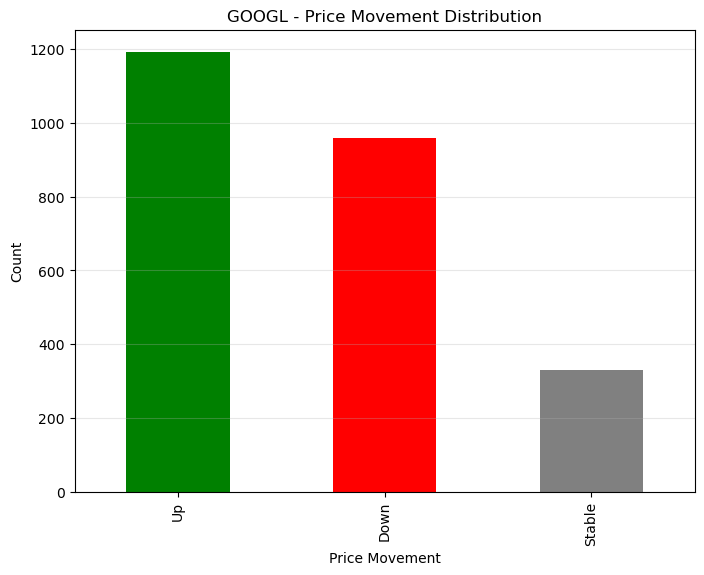

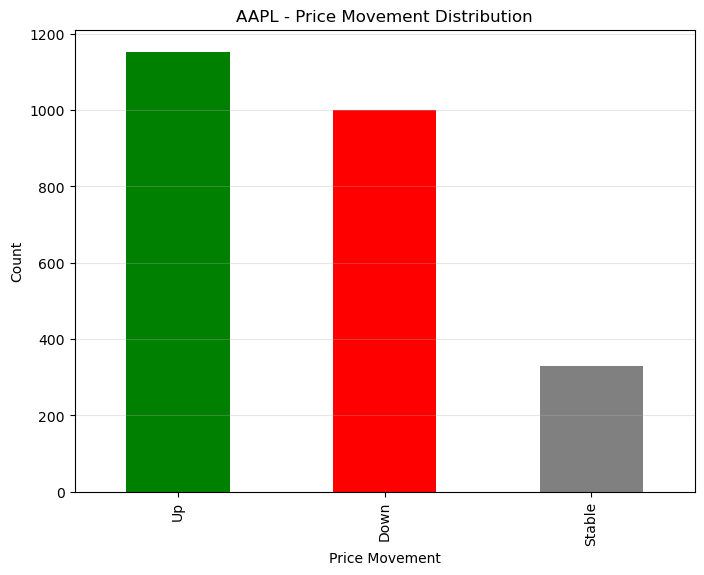

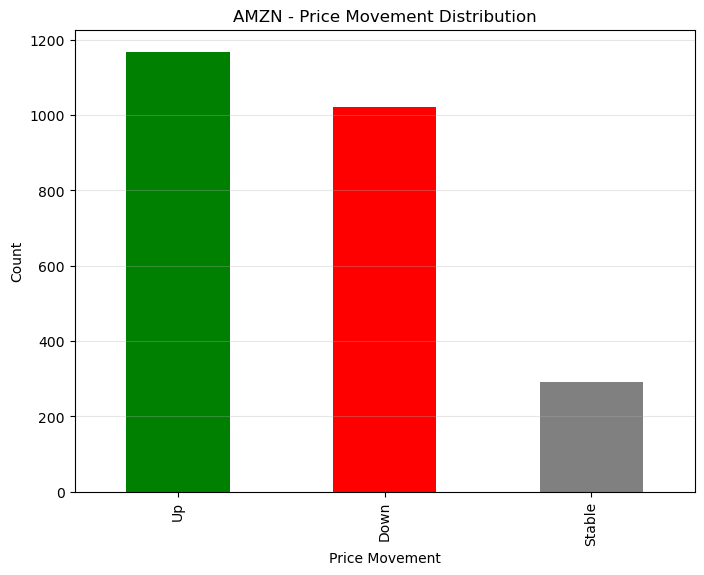

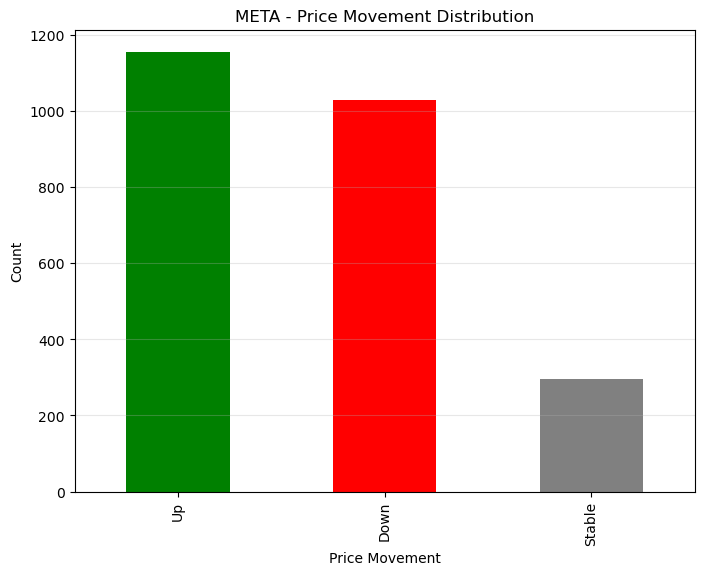

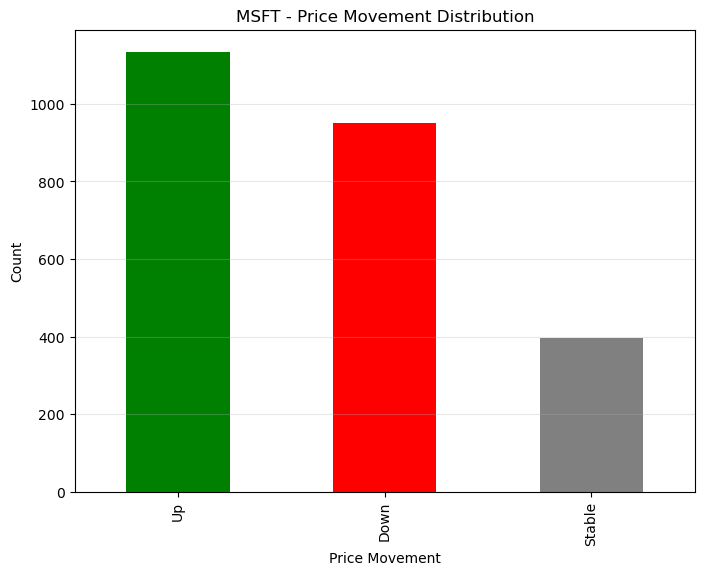

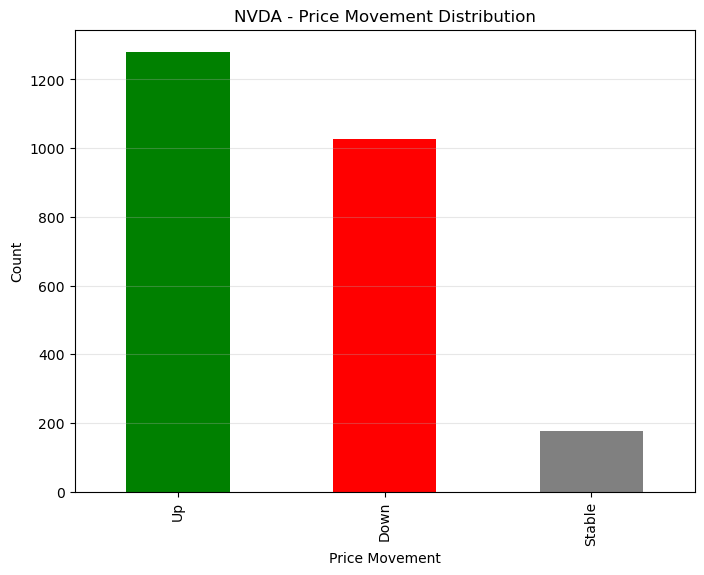

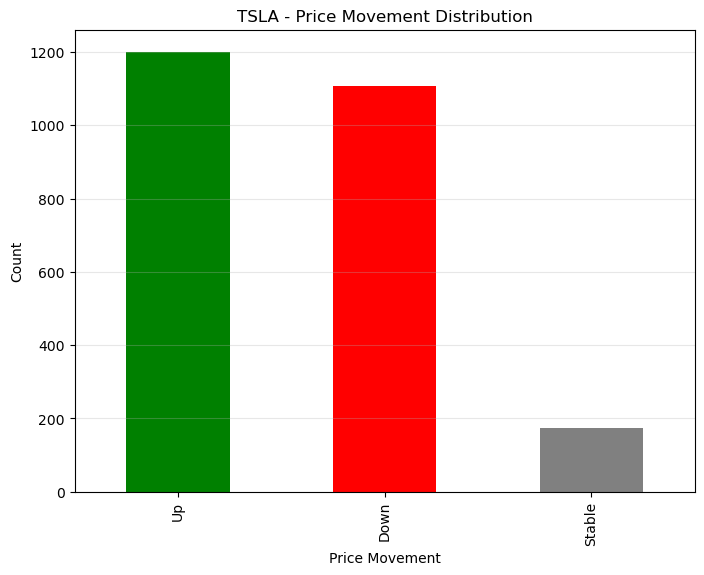

In [7]:
threshold = 0.002
def plot_price_movement_distribution(stock_dict, threshold=0.002):
    """For each ticker create a bar plot showing the distribution of price movements:
       - 'Up' if LOG_RETURN > threshold
       - 'Down' if LOG_RETURN < -threshold
       - 'Stable' otherwise
       Saves each figure to save_dir/{TICKER}_price_movement_distribution.png
    """

    for ticker, df in stock_dict.items():
        if 'LOG_RETURN' not in df.columns:
            continue

        # Classify movements
        conditions = [
            (df['LOG_RETURN'] > threshold),
            (df['LOG_RETURN'] < -threshold)
        ]
        choices = ['Up', 'Down']
        df['Price_Movement'] = pd.Series(np.select(conditions, choices, default='Stable'))

        # Count occurrences
        movement_counts = df['Price_Movement'].value_counts().reindex(['Up', 'Down', 'Stable'], fill_value=0)

        # Plotting
        fig, ax = plt.subplots(figsize=(8, 6))
        movement_counts.plot(kind='bar', color=['green', 'red', 'gray'], ax=ax)
        ax.set_title(f'{ticker} - Price Movement Distribution')
        ax.set_ylabel('Count')
        ax.set_xlabel('Price Movement')
        ax.grid(True, axis='y', alpha=0.3)
        plt.show()

# Create bar plots for price movement distribution
plot_price_movement_distribution(stock_data, threshold=threshold)

## PACF del Rendimiento Logaritmico y Precio de Cierre (Lag = 1 día)

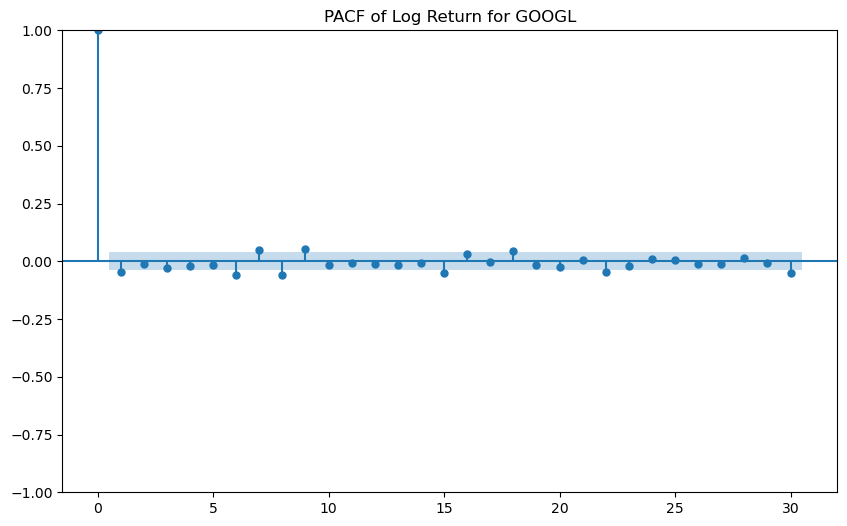

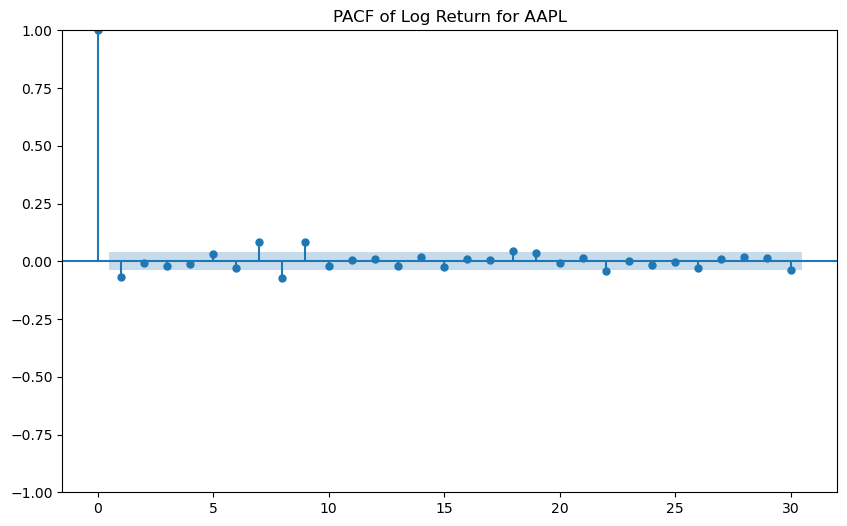

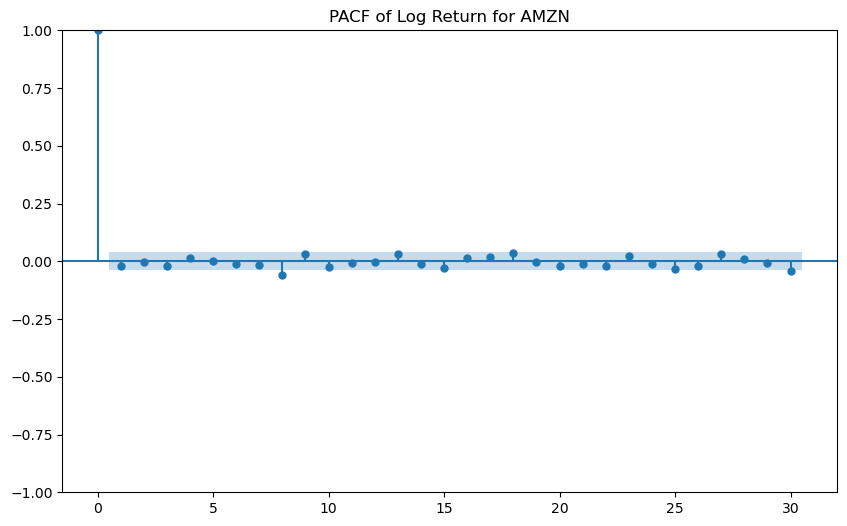

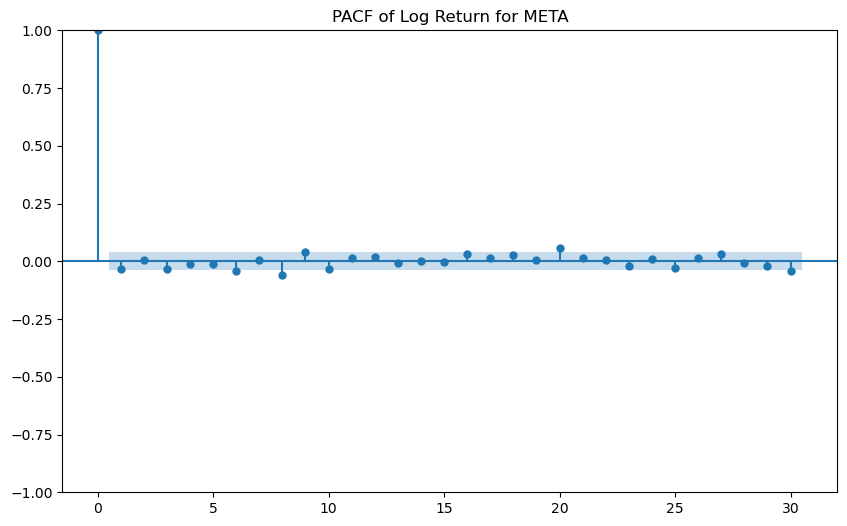

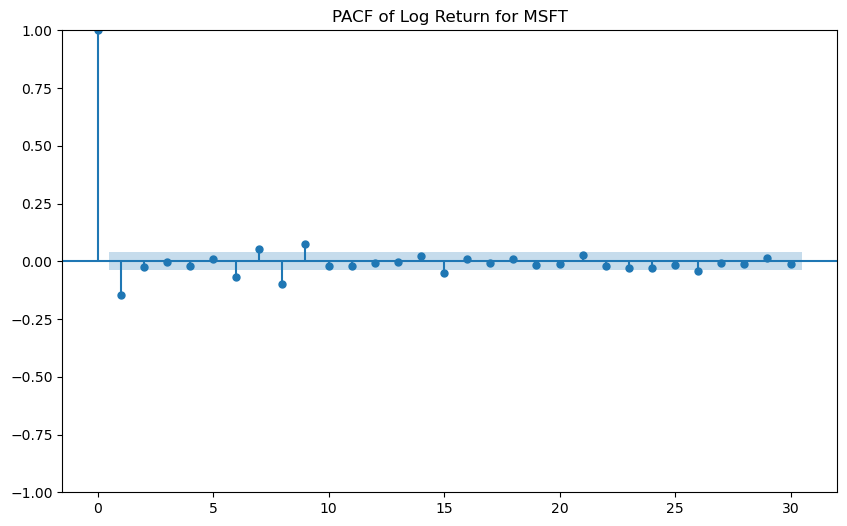

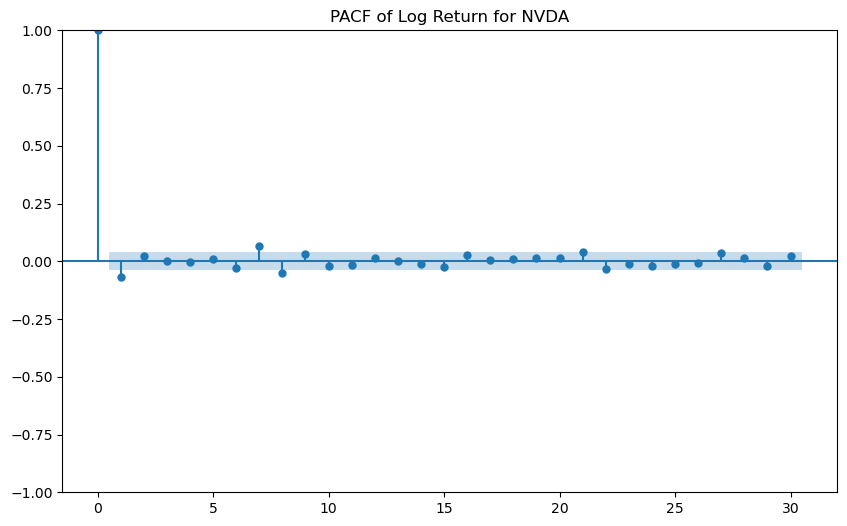

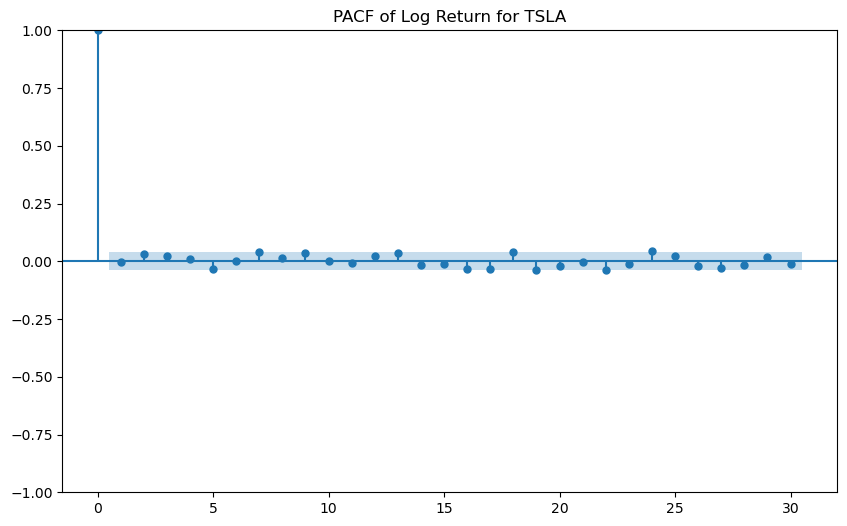

In [8]:
# Generar gráficos PACF con lag=1 para cada ticker
for ticker, df in stock_data.items():
    if 'LOG_RETURN' in df.columns:
        fig, ax = plt.subplots(figsize=(10, 6))
        plot_pacf(df['LOG_RETURN'], lags=30, ax=ax, title=f'PACF of Log Return for {ticker}', method='ywm')
        plt.show()

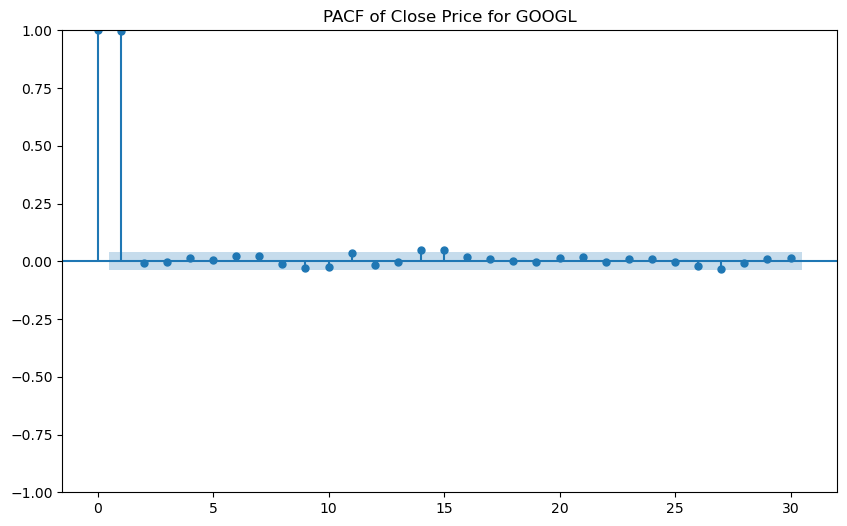

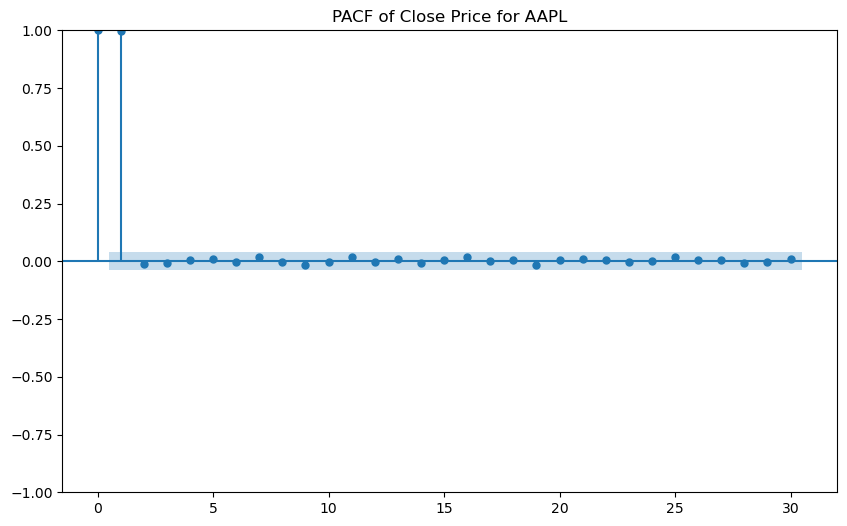

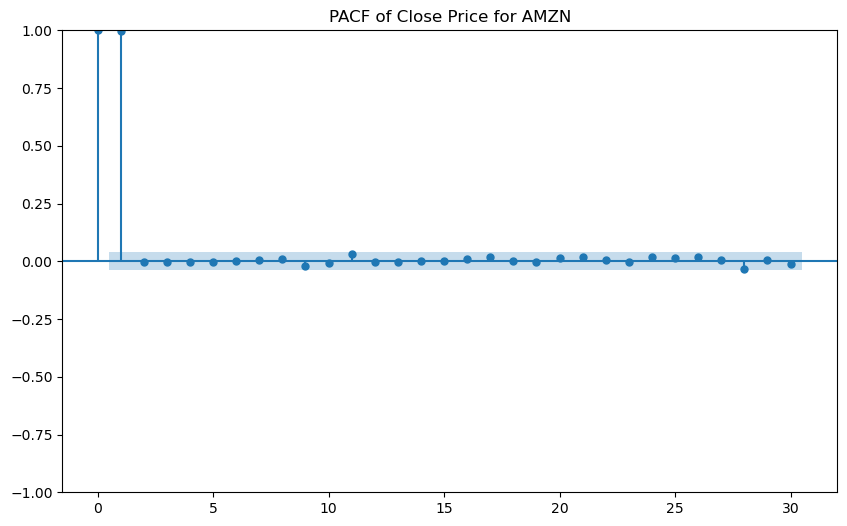

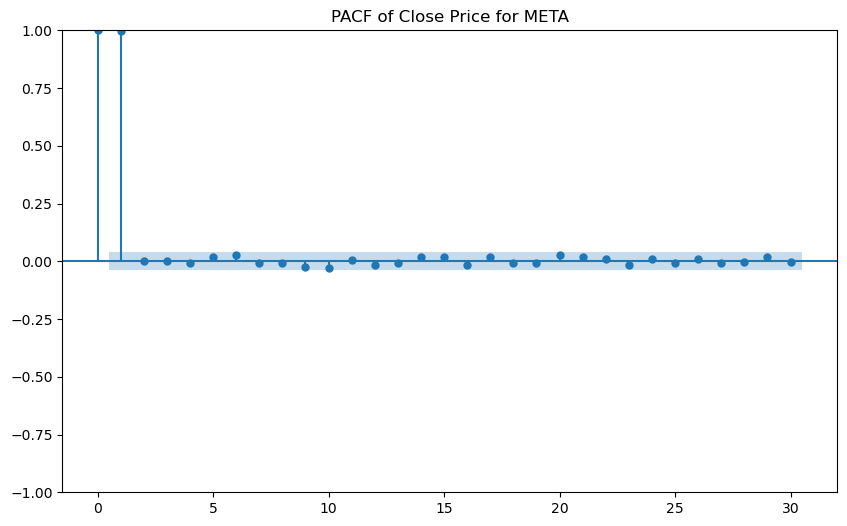

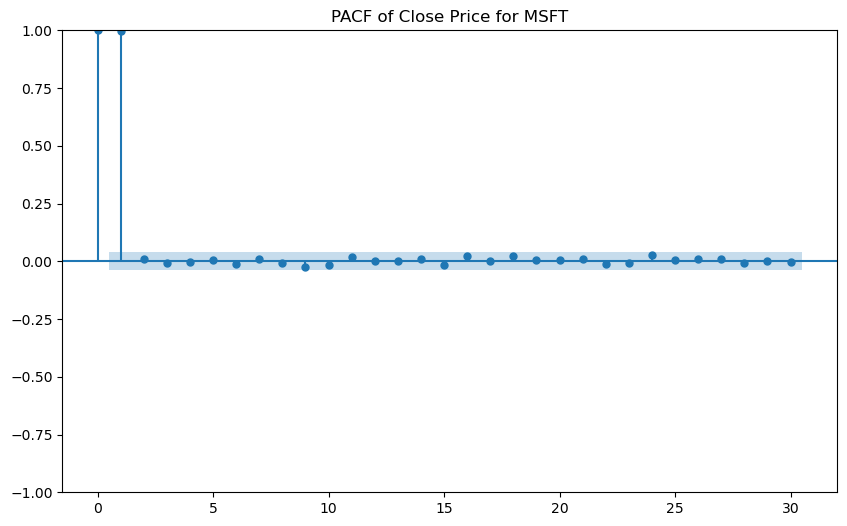

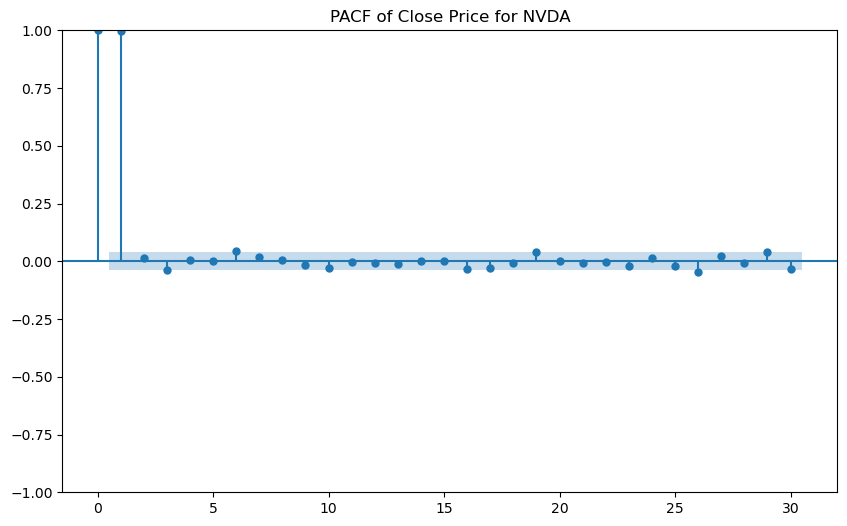

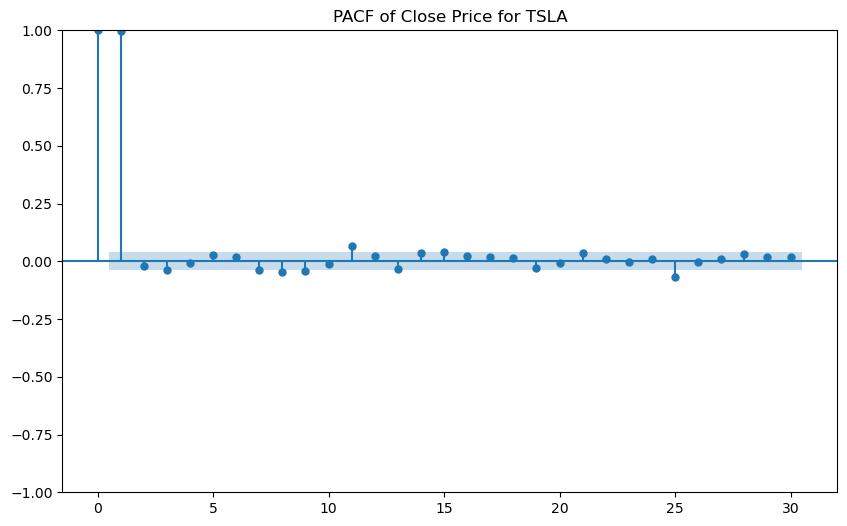

In [17]:
for ticker, df in stock_data.items():
    if 'Close' in df.columns:
        fig, ax = plt.subplots(figsize=(10, 6))
        plot_pacf(df['Close'], lags=30, ax=ax, title=f'PACF of Close Price for {ticker}', method='ywm')
        plt.show()

## Prueba de Dickey-Fuller Aumentada (ADF)

La prueba ADF verifica si una serie temporal es estacionaria. 
- **H0 (hipótesis nula)**: La serie tiene una raíz unitaria (no es estacionaria)
- **H1 (hipótesis alternativa)**: La serie es estacionaria

Si **p-value < 0.05**, rechazamos H0 y concluimos que la serie es estacionaria.

In [10]:
# Realizar prueba ADF para Close Price y LOG_RETURN de cada ticker
for ticker, df in stock_data.items():
    print(f"\n{'='*70}")
    print(f"Prueba ADF para {ticker}")
    print(f"{'='*70}")
    
    # Test para Close Price
    close_values = df['Close'].dropna()
    adf_result = adfuller(close_values, autolag='AIC')
        
    print(f"\n--- Close Price ---")
    print(f"ADF Statistic: {adf_result[0]:.6f}")
    print(f"p-value: {adf_result[1]:.6f}")
    print(f"Valores críticos:")
    for key, value in adf_result[4].items():
        print(f"  {key}: {value:.3f}")
        
    
    # Test para LOG_RETURN
    # Eliminar valores NaN
    log_return_values = df['LOG_RETURN'].dropna()
    adf_result = adfuller(log_return_values, autolag='AIC')
        
    print(f"\n--- LOG_RETURN ---")
    print(f"ADF Statistic: {adf_result[0]:.6f}")
    print(f"p-value: {adf_result[1]:}")
    print(f"Valores críticos:")
    for key, value in adf_result[4].items():
        print(f"  {key}: {value:.3f}")
        




Prueba ADF para GOOGL

--- Close Price ---
ADF Statistic: 0.717368
p-value: 0.990178
Valores críticos:
  1%: -3.433
  5%: -2.863
  10%: -2.567

--- LOG_RETURN ---
ADF Statistic: -17.095391
p-value: 7.540670780878216e-30
Valores críticos:
  1%: -3.433
  5%: -2.863
  10%: -2.567

Prueba ADF para AAPL

--- Close Price ---
ADF Statistic: 0.863351
p-value: 0.992593
Valores críticos:
  1%: -3.433
  5%: -2.863
  10%: -2.567

--- LOG_RETURN ---
ADF Statistic: -15.506591
p-value: 2.378005197852168e-28
Valores críticos:
  1%: -3.433
  5%: -2.863
  10%: -2.567

Prueba ADF para AMZN

--- Close Price ---
ADF Statistic: -0.251568
p-value: 0.932089
Valores críticos:
  1%: -3.433
  5%: -2.863
  10%: -2.567

--- LOG_RETURN ---
ADF Statistic: -50.719444
p-value: 0.0
Valores críticos:
  1%: -3.433
  5%: -2.863
  10%: -2.567

Prueba ADF para META

--- Close Price ---
ADF Statistic: 0.774490
p-value: 0.991213
Valores críticos:
  1%: -3.433
  5%: -2.863
  10%: -2.567

--- LOG_RETURN ---
ADF Statistic: -17.

## Volatilidad Histórica

La volatilidad histórica mide la variabilidad de los retornos de un activo en un período determinado. Se calcula como la desviación estándar de los retornos logarítmicos, anualizada multiplicando por $\sqrt{252}$ (número de días de trading al año).

VOLATILIDAD HISTÓRICA ANUALIZADA

GOOGL:
  Volatilidad Diaria: 0.017933 (1.7933%)
  Volatilidad Anualizada: 0.284670 (28.47%)

AAPL:
  Volatilidad Diaria: 0.017914 (1.7914%)
  Volatilidad Anualizada: 0.284379 (28.44%)

AMZN:
  Volatilidad Diaria: 0.020471 (2.0471%)
  Volatilidad Anualizada: 0.324960 (32.50%)

META:
  Volatilidad Diaria: 0.023945 (2.3945%)
  Volatilidad Anualizada: 0.380122 (38.01%)

MSFT:
  Volatilidad Diaria: 0.017003 (1.7003%)
  Volatilidad Anualizada: 0.269915 (26.99%)

NVDA:
  Volatilidad Diaria: 0.030476 (3.0476%)
  Volatilidad Anualizada: 0.483795 (48.38%)

TSLA:
  Volatilidad Diaria: 0.036047 (3.6047%)
  Volatilidad Anualizada: 0.572223 (57.22%)



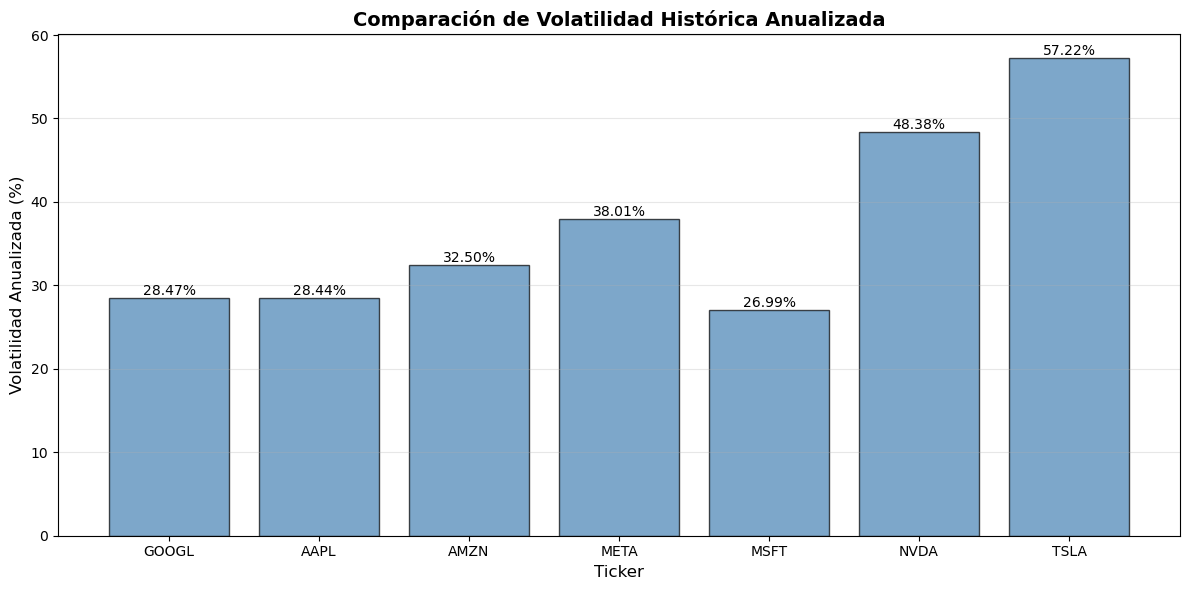

In [11]:
# Calcular volatilidad histórica para cada ticker
# Número de días de trading al año
TRADING_DAYS = 252

print("="*70)
print("VOLATILIDAD HISTÓRICA ANUALIZADA")
print("="*70)

volatility_results = {}

for ticker, df in stock_data.items():
    if 'LOG_RETURN' in df.columns:
        # Eliminar valores NaN
        log_returns = df['LOG_RETURN'].dropna()
        
        # Calcular volatilidad histórica (desviación estándar anualizada)
        daily_volatility = log_returns.std()
        annual_volatility = daily_volatility * np.sqrt(TRADING_DAYS)
        
        # Guardar resultados
        volatility_results[ticker] = {
            'daily_volatility': daily_volatility,
            'annual_volatility': annual_volatility
        }
        
        print(f"\n{ticker}:")
        print(f"  Volatilidad Diaria: {daily_volatility:.6f} ({daily_volatility*100:.4f}%)")
        print(f"  Volatilidad Anualizada: {annual_volatility:.6f} ({annual_volatility*100:.2f}%)")

print("\n" + "="*70)

# Crear gráfico comparativo de volatilidad anualizada
fig, ax = plt.subplots(figsize=(12, 6))

tickers = list(volatility_results.keys())
annual_vols = [volatility_results[t]['annual_volatility'] * 100 for t in tickers]

bars = ax.bar(tickers, annual_vols, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_ylabel('Volatilidad Anualizada (%)', fontsize=12)
ax.set_xlabel('Ticker', fontsize=12)
ax.set_title('Comparación de Volatilidad Histórica Anualizada', fontsize=14, fontweight='bold')
ax.grid(True, axis='y', alpha=0.3)

# Añadir valores encima de las barras
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### Volatilidad Histórica Rodante (30 días)

La volatilidad rodante muestra cómo ha evolucionado la volatilidad a lo largo del tiempo, calculándola en ventanas móviles.

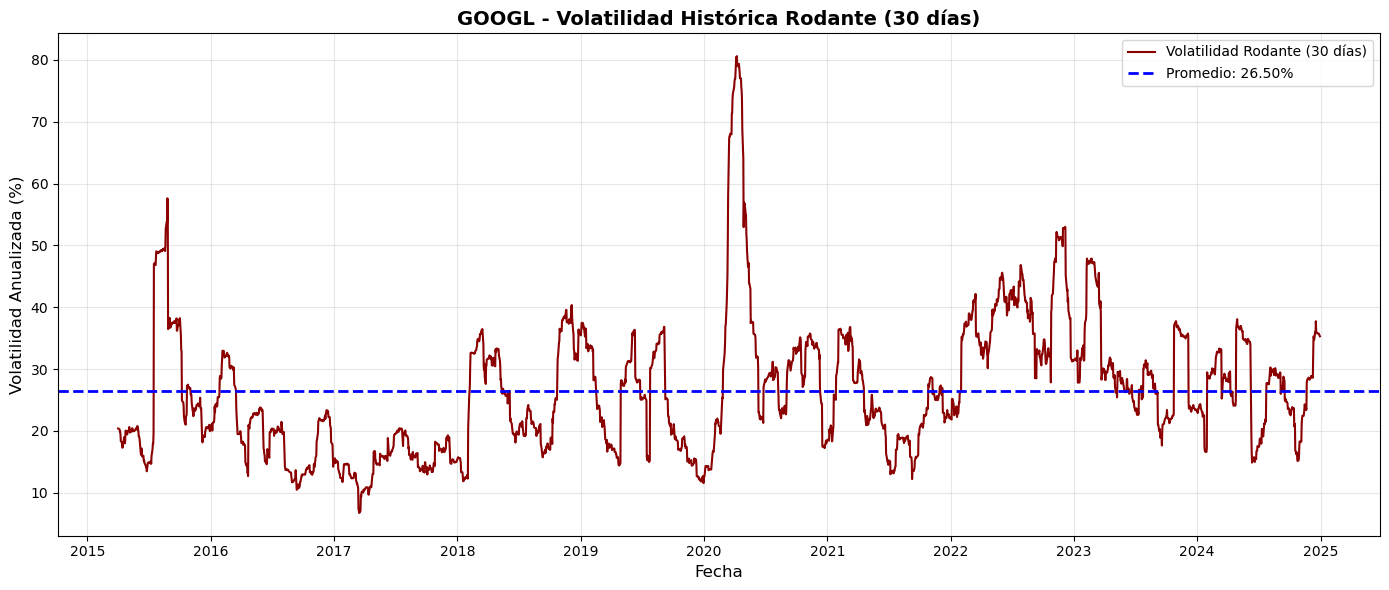

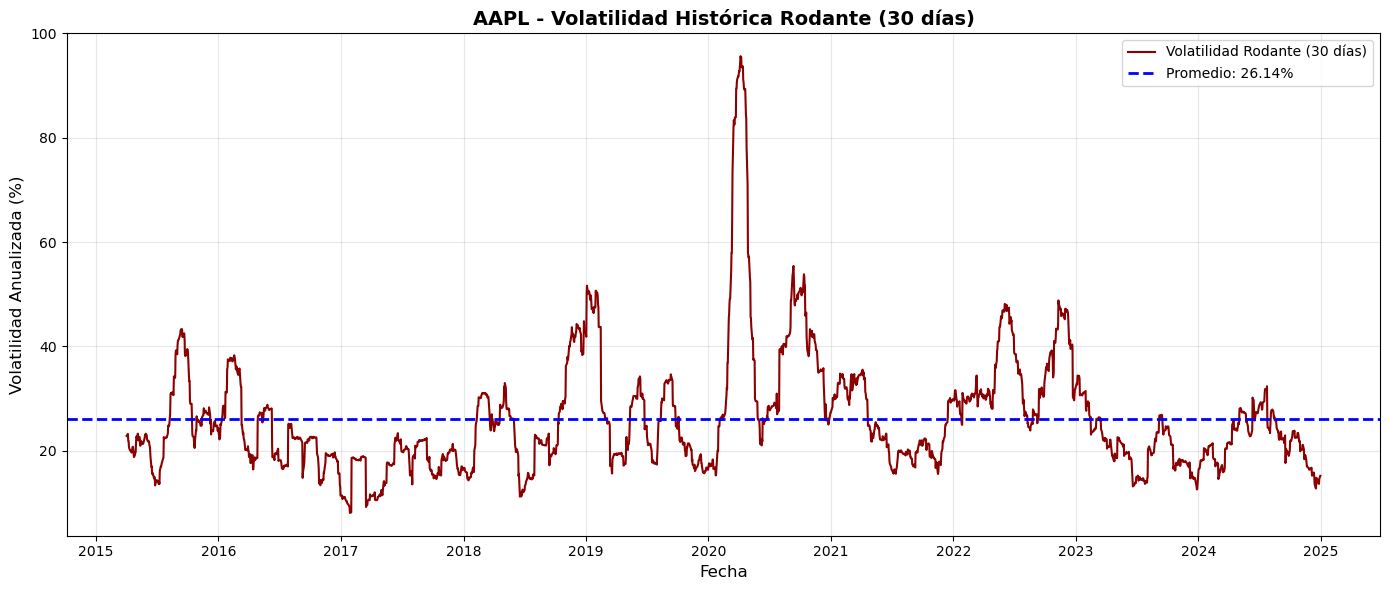

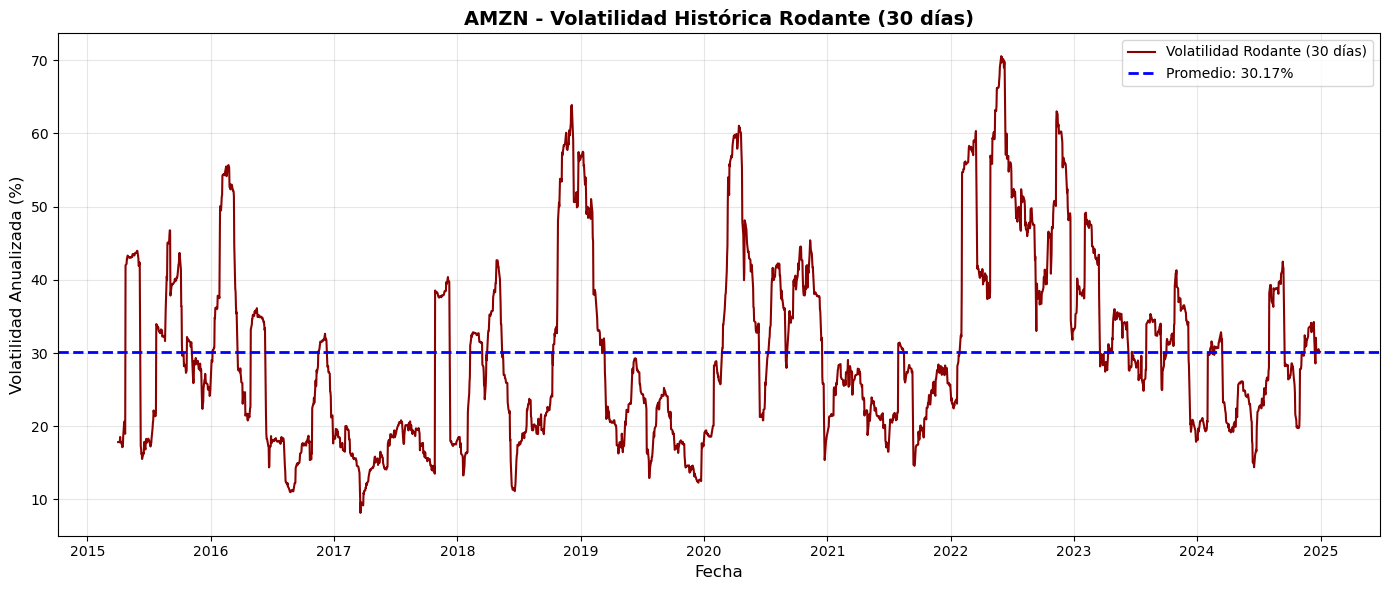

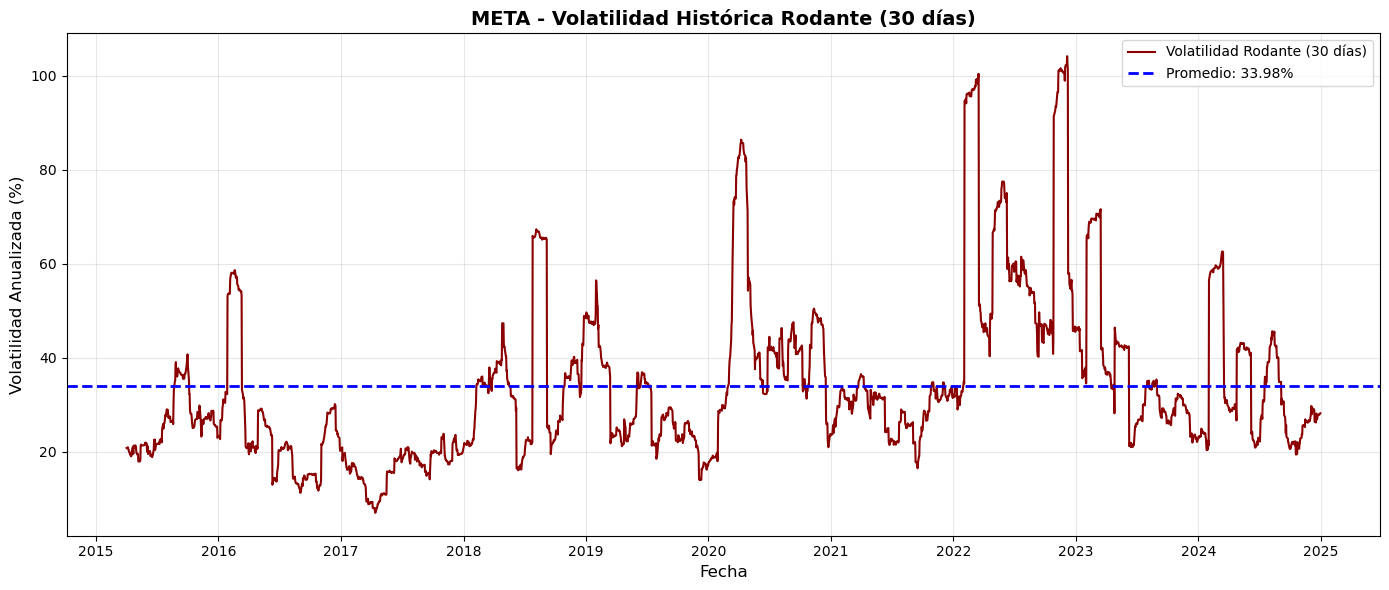

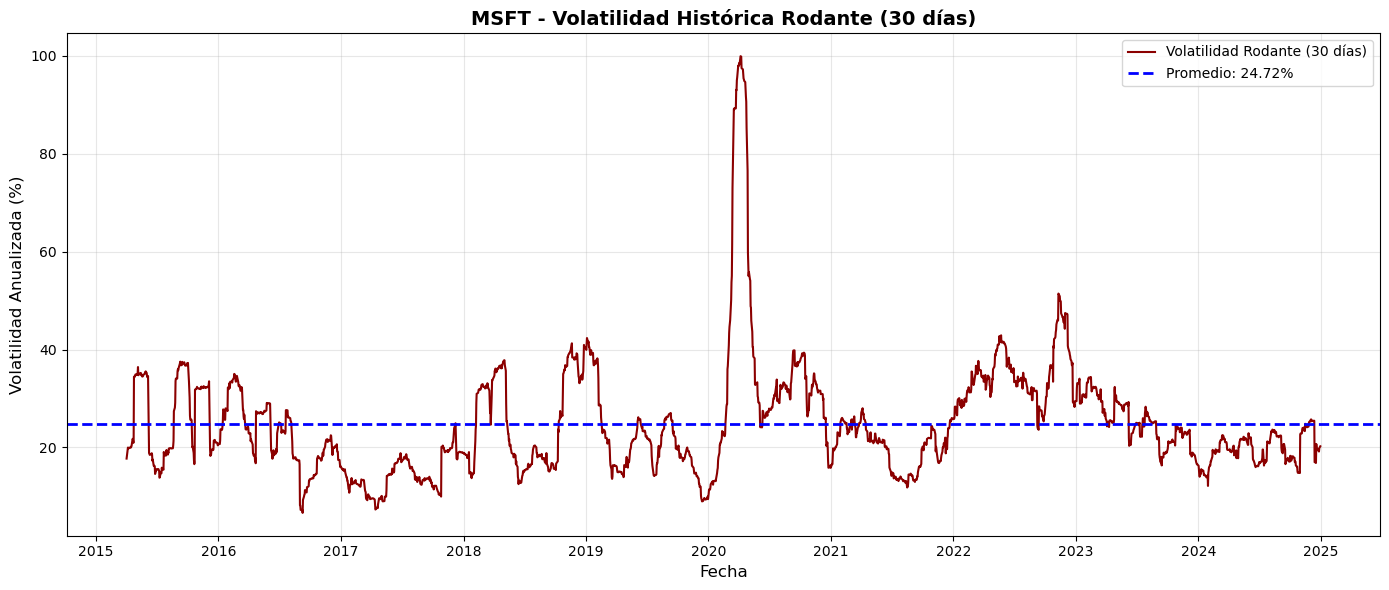

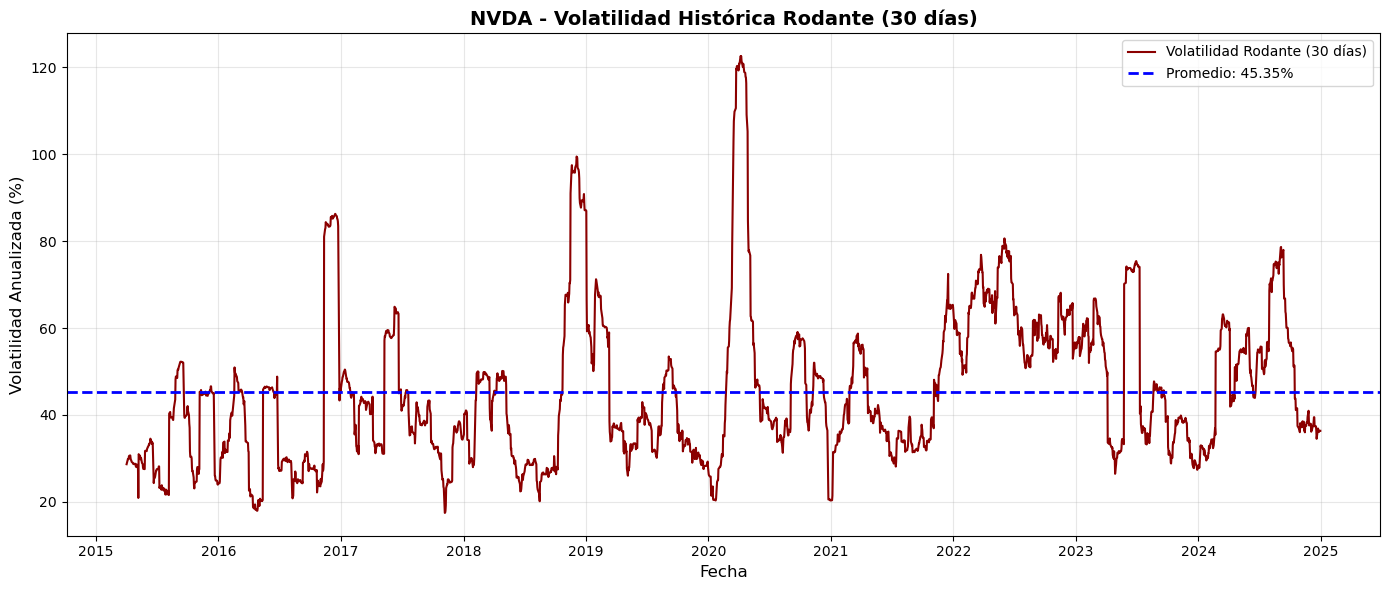

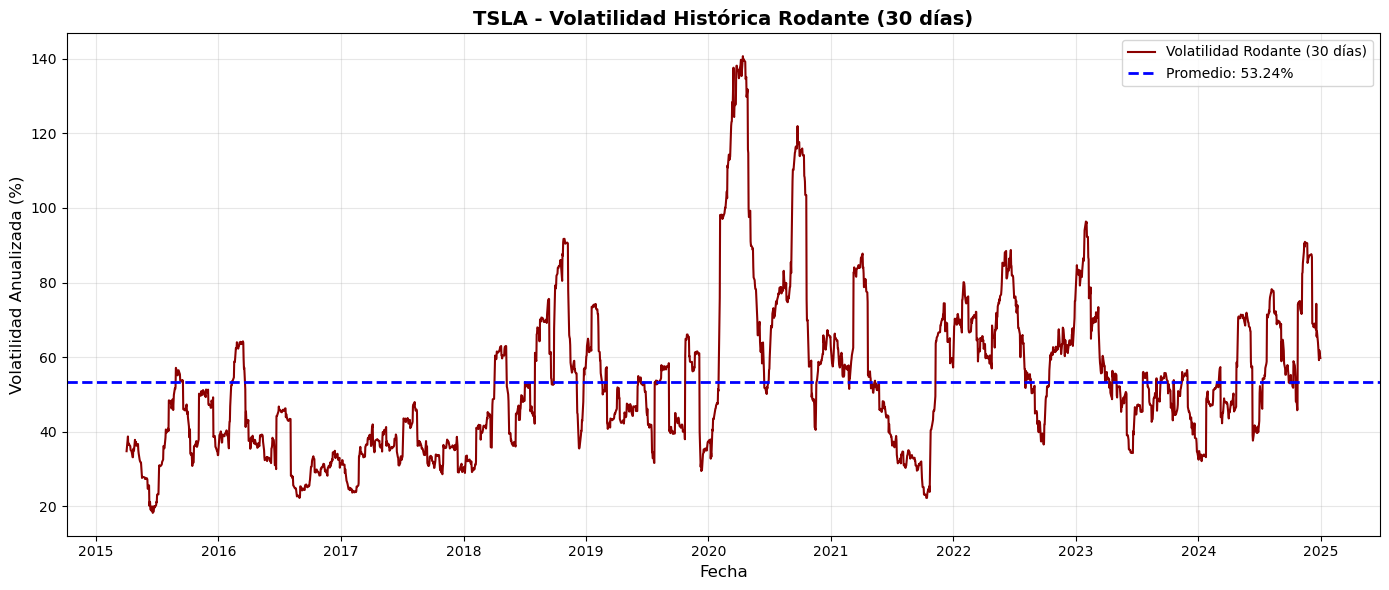

In [12]:
# Calcular y graficar volatilidad rodante (30 días) para cada ticker
window = 30  # Ventana de 30 días

for ticker, df in stock_data.items():
    if 'LOG_RETURN' in df.columns and 'Date' in df.columns:
        # Calcular volatilidad rodante
        rolling_volatility = df['LOG_RETURN'].rolling(window=window).std() * np.sqrt(TRADING_DAYS)
        
        # Crear gráfico
        fig, ax = plt.subplots(figsize=(14, 6))
        
        ax.plot(df['Date'], rolling_volatility * 100, label=f'Volatilidad Rodante ({window} días)', 
                color='darkred', linewidth=1.5)
        ax.axhline(y=rolling_volatility.mean() * 100, color='blue', linestyle='--', 
                   linewidth=2, label=f'Promedio: {rolling_volatility.mean()*100:.2f}%')
        
        ax.set_xlabel('Fecha', fontsize=12)
        ax.set_ylabel('Volatilidad Anualizada (%)', fontsize=12)
        ax.set_title(f'{ticker} - Volatilidad Histórica Rodante ({window} días)', 
                     fontsize=14, fontweight='bold')
        ax.legend(loc='upper right', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()